### [Exp_10] 단어 Level로 번역기 업그레이드하기

##### Step 0. 라이브러리 및 데이터 로드

In [61]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model 
import numpy as np
import re, os

import warnings
warnings.filterwarnings("ignore")

In [62]:
# file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
file_path = '/content/drive/MyDrive/data/translater/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
140785,I don't have any objection to that.,Je n'ai aucune objection à ça.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
98333,They met each other halfway.,Elles se sont rencontrées à mi-chemin.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
1743,Can I help?,Puis-je aider ?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
68399,"When it rains, it pours.",Un malheur n'arrive jamais seul.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
26417,This is irregular.,C'est irrégulier.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [63]:
# lines = lines[['eng', 'fra']][:70000] # 7만개 샘플 사용
lines = lines[['eng', 'fra']][:] # 7만개 샘플 사용
lines.sample(5)

,eng,fra
24140,I like your style.,J'apprécie votre style.
138679,We only sell top quality products.,Nous ne vendons que des produits de haute qual...
137402,She didn't feel like eating lunch.,Elle n'eut pas envie de déjeuner.
50907,I'm very drawn to you.,Vous m'attirez beaucoup.
79536,I know who asked you here.,Je sais qui t'a requis ici.


##### Step1. 정제. 정규화, 전처리(영어, 프랑스 모두!)

In [65]:
# 1. 구두점(Punctuation)을 단어와 분리해주세요.
# 2. 소문자로 바꿔주세요.
# 3. 띄어쓰기 단위로 토큰를 수행하세요.
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = sentence.replace('\t', ' ').replace('\n', ' ')
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip()
    return sentence

lines['eng'] = lines['eng'].apply(lambda x : preprocess_sentence(x))
lines['fra'] = lines['fra'].apply(lambda x : preprocess_sentence(x))

lines.sample(5)

,eng,fra
52970,tom gets upset easily .,tom est facilement contrari .
99845,why don t you come visit us ?,pourquoi ne viens tu pas nous voir ?
120696,we must reflect on our failure .,il faut que nous nous penchions sur nos checs .
191259,"when i cough twice , that s your cue to come i...","quand je tousse deux fois , c est le signal qu..."
110357,i missed the last two lessons .,j ai rat les deux derniers cours .


##### Step2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

In [66]:
# 시작 토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')
print('전체 샘플의 수 :',len(lines))
lines.head(5)

전체 샘플의 수 : 197463


,eng,fra
0,go .,\t va ! \n
1,go .,\t marche . \n
2,go .,\t en route ! \n
3,go .,\t bouge ! \n
4,hi .,\t salut ! \n


##### Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

In [67]:
eng_tokenizer = Tokenizer(char_level=False, filters="")   # 문자 단위로 Tokenizer를 생성합니다. , filter='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n' 
# eng_tokenizer = Tokenizer(char_level=False)   # 문자 단위로 Tokenizer를 생성합니다. , filter='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n' 
eng_tokenizer.fit_on_texts(lines.eng)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:10]

[[48, 1],
 [48, 1],
 [48, 1],
 [48, 1],
 [2385, 1],
 [2385, 1],
 [412, 111],
 [412, 111],
 [412, 111],
 [412, 111]]

In [68]:
fra_tokenizer = Tokenizer(char_level=False, filters="")   # 문자 단위로 Tokenizer를 생성합니다. 
# fra_tokenizer = Tokenizer(char_level=False, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:10]

[[1, 118, 44, 2],
 [1, 814, 3, 2],
 [1, 29, 631, 44, 2],
 [1, 2381, 44, 2],
 [1, 3076, 44, 2],
 [1, 3076, 3, 2],
 [1, 552, 44, 2],
 [1, 4706, 44, 2],
 [1, 558, 210, 1728, 210, 9653, 44, 2],
 [1, 2560, 44, 2]]

In [69]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 15269
프랑스어 단어장의 크기 : 21398


In [70]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 52
프랑스어 시퀀스의 최대 길이 68


In [71]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 197463
영어 단어장의 크기 : 15269
프랑스어 단어장의 크기 : 21398
영어 시퀀스의 최대 길이 52
프랑스어 시퀀스의 최대 길이 68


In [72]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ word for word in line if word != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ word for word in line if word != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [73]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 118, 44], [1, 814, 3], [1, 29, 631, 44]]
[[118, 44, 2], [814, 3, 2], [29, 631, 44, 2]]


In [74]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (197463, 52)
프랑스어 입력데이터의 크기(shape) : (197463, 68)
프랑스어 출력데이터의 크기(shape) : (197463, 68)


In [75]:
# word단위로 embedding사용시 one-hot encoding적용안함.
# encoder_input = to_categorical(encoder_input)
# decoder_input = to_categorical(decoder_input)
# decoder_target = to_categorical(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (197463, 52)
프랑스어 입력데이터의 크기(shape) : (197463, 68)
프랑스어 출력데이터의 크기(shape) : (197463, 68)


In [76]:
n_of_val = 10000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (197463, 52)
프랑스어 학습 입력데이터의 크기(shape) : (197463, 68)
프랑스어 학습 출력데이터의 크기(shape) : (197463, 68)


##### Step 4. 임베딩 층(Embedding layer) 사용하기

In [78]:
word_vector_dim = 256

# encoding용 임베딩
enc_emb =  Embedding(eng_vocab_size, word_vector_dim)

# decoding용 임베딩
dec_emb =  Embedding(fra_vocab_size, word_vector_dim)


##### Step 5. 모델 구현하기

In [79]:
# 입력 텐서 생성.
encoder_inputs = Input(shape=(max_eng_seq_len,))

# enc_vocab_size x word_vector_dim 의 embedding layer
enc_out = enc_emb(encoder_inputs)

# # hidden size가 256인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(units = 256, return_state = True)

# # 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(enc_out)
# # hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

In [80]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(max_fra_seq_len,))
dec_emb =  Embedding(fra_vocab_size, word_vector_dim)

dec_out = dec_emb(decoder_inputs)

# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm2 = LSTM(units = 256, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state

decoder_outputs, _, _= decoder_lstm2(dec_out, initial_state = encoder_states)

In [81]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 52)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 68)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 52, 256)      3908864     ['input_6[0][0]']                
                                                                                                  
 embedding_6 (Embedding)        (None, 68, 256)      5477888     ['input_7[0][0]']                
                                                                                            

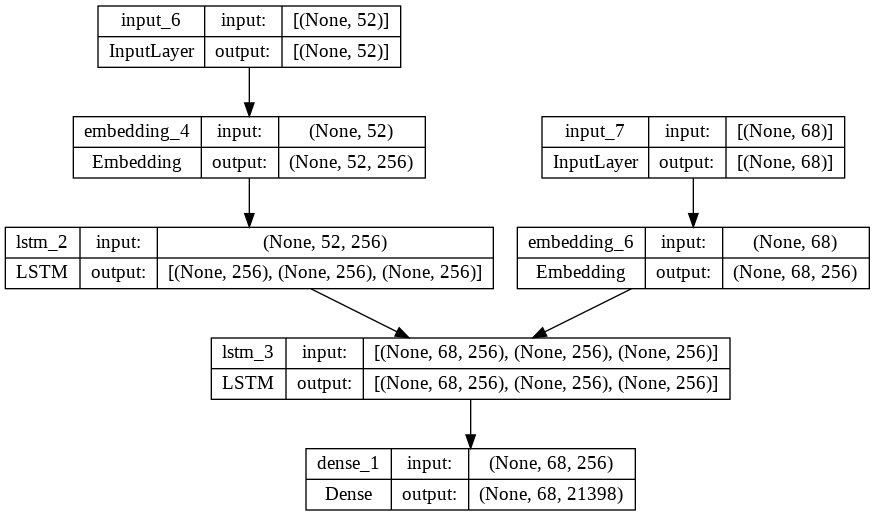

In [82]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
model.summary()

plot_model(model, show_shapes=True)


In [84]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=10)

Epoch 1/10
1465/1465 [==============================] - 214s 146ms/step - loss: 0.5782 - val_loss: 1.2214
Epoch 2/10
1465/1465 [==============================] - 214s 146ms/step - loss: 0.4547 - val_loss: 1.0967
Epoch 3/10
1465/1465 [==============================] - 214s 146ms/step - loss: 0.3981 - val_loss: 1.0376
Epoch 4/10
1465/1465 [==============================] - 214s 146ms/step - loss: 0.3629 - val_loss: 1.0037
Epoch 5/10
1465/1465 [==============================] - 214s 146ms/step - loss: 0.3354 - val_loss: 0.9889
Epoch 6/10
1465/1465 [==============================] - 214s 146ms/step - loss: 0.3140 - val_loss: 0.9787
Epoch 7/10
1465/1465 [==============================] - 214s 146ms/step - loss: 0.2986 - val_loss: 0.9721
Epoch 8/10
1465/1465 [==============================] - 214s 146ms/step - loss: 0.2801 - val_loss: 0.9684
Epoch 9/10
1465/1465 [==============================] - 214s 146ms/step - loss: 0.2647 - val_loss: 0.9716
Epoch 10/10
1465/1465 [=======================

In [85]:
# Loss, Accuracy 그래프 시각화
import matplotlib.pyplot as plt

def draw_loss(history):
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



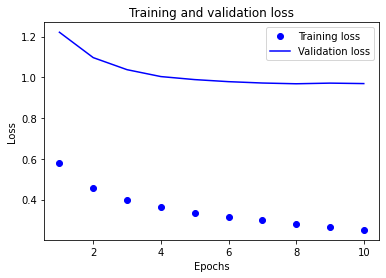

In [86]:
draw_loss(history)

In [87]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 52)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 52, 256)           3908864   
                                                                 
 lstm_2 (LSTM)               [(None, 256),             525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 4,434,176
Trainable params: 4,434,176
Non-trainable params: 0
_________________________________________________________________


In [88]:
decoder_input.shape

(197463, 68)

In [89]:
enc_out.shape

TensorShape([None, 52, 256])

In [90]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

test_decoder_inputs = Input(shape=(1,))
test_dec_out = dec_emb(test_decoder_inputs)

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm2(test_dec_out, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        multiple             5477888     ['input_10[0][0]']               
                                                                                                  
 input_8 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 256)]        0           []                               
                                                                                            

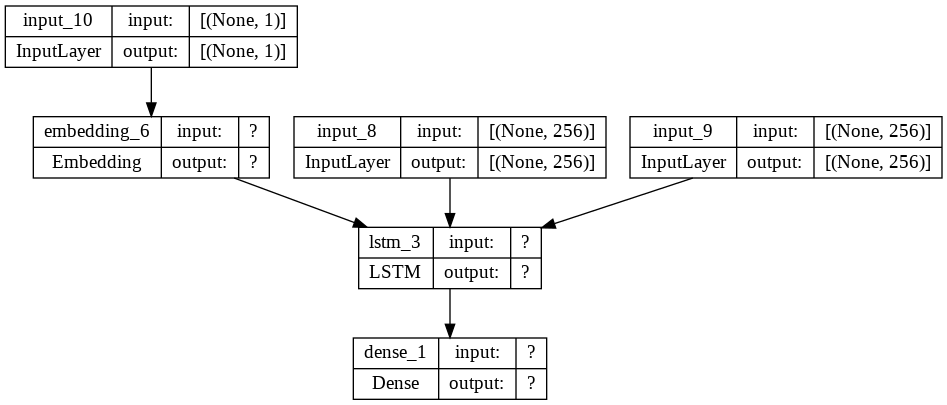

In [91]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[test_decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

plot_model(decoder_model, show_shapes=True)

##### Step 6. 모델 평가하기

In [92]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [30]:
def decode_sequence_word(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['\t']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        try:
            sampled_char = idx2fra[sampled_token_index]
        except:
            print('error no fra index')

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [94]:
import numpy as np
import random

for seq_index in random.sample(range(len(encoder_input)), 10): # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence_word(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

1/1 [==============================] - 0s 18ms/step
-----------------------------------
입력 문장: you seem happy .
정답 문장:  tu sembles heureuse . 
번역기가 번역한 문장:  tu as l air tr s bien . 
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: tom continued to talk to mary .
정답 문장:  tom a continu parler marie . 
번역기가 번역한 문장:  tom a d cid de se suicider . 
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: my neighbors are very nice people .
정답 문장:  mes voisins sont des gens tr s gentils . 
번역기가 번역한 문장:  les gens me font tr s bien . 
1/1 [==============================] - 0s 15ms/step
-----------------------------------
입력 문장: don t forget that .
정답 문장:  n oubliez pas a . 
번역기가 번역한 문장:  n oublie pas de cela . 
1/1 [==============================] - 0s 17ms/step
-----------------------------------
입력 문장: you seem to be depressed this morning . what s the matter ?
정답 문장:  tu sembles d prim e , ce matin . que ce p

##### Step 7. 회고  

- Seq2Seq구조를 테스트하는 좋은 기회 였는데, tensorflow의 graph 구조와 실제  데이터를 이용하여 동작할때가 구분되지 않아 어려움이 있었다. Tensor는 단순 데이터가 아니라 Node(input, layer)의 정보가 포함되어 있는듯 하다..  
- 데이터 크기가 많아야 번역이 풍부해짐을 알 수 있었다.  
- Embedding레이어가 추가되는 경우, 4차원입력이되어 LSTM 3dim입력과 맞지 않아 원-핫 인코딩을 하지 않아야 했다.  
- Loss 함수도 sparse_categorical_crossentropy 변경해주어야 올바로 동작했다.  